# YOLOv8 demo - custom model

In [ ]:
# Install YOLOv8
%pip install ultralytics
%pip install opencv-python

In [1]:
# Import YOLOv8
from ultralytics import YOLO

# Import image visualization
import cv2

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
# Move data to datasets folder that YOLOv8 expects
!rm -rf ./ai-demos
!rm -rf ./datasets
!git clone https://github.com/tkubica12/ai-demos
!mv -f ./ai-demos/yolo/datasets .

Cloning into 'ai-demos'...
remote: Enumerating objects: 336, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 336 (delta 18), reused 135 (delta 15), pack-reused 195
Receiving objects: 100% (336/336), 93.50 MiB | 22.38 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Updating files: 100% (228/228), done.


## Fresh model from few data
Here we will use YOLOv8 with no pretraining and train on our very very small dataset. Can workout well for our extremly simple example, but in practice big high quality dataset will be needed to get good results.

Best for highly specialised visual tasks where transfer learning will not help, eg. medical images.

In [ ]:
# Show one image from dataset
%matplotlib inline
from matplotlib import pyplot as plt
img = cv2.imread("./datasets/2plysaci/train/images/20181209_093257_jpg.rf.9e5de39c501d75369ffa14627baaa318.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [14]:
# Load empty model
model = YOLO('yolov8n.yaml')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [15]:
# Train the model
train = model.train(data='./datasets/2plysaci.yaml', epochs=2000, patience=0, imgsz=1024)

# 2000 epochs completed in 0.507 hours.

New https://pypi.org/project/ultralytics/8.0.121 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.120 🚀 Python-3.8.5 torch-1.12.0 CUDA:0 (NVIDIA A100 80GB PCIe, 80995MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=./datasets/2plysaci.yaml, epochs=2000, patience=0, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width

In [24]:
# Find folder with latest run of training
import os

files = os.listdir("runs/detect/")
max_number = 0
latest_run = ""
for file in files:
    if file.split("train")[1]:
        number = int(file.split("train")[1])
        max_number = max(max_number, number)
if max_number == 0:
    latest_run = "runs/detect/train"
else:
    latest_run = "runs/detect/train" + str(max_number)
print(latest_run)

runs/detect/train29



image 1/1 /mnt/batch/tasks/shared/LS_root/mounts/clusters/a100/code/datasets/2plysaci/test/20181209_092837.jpg: 768x1024 1 oslik, 1 ovecka, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)


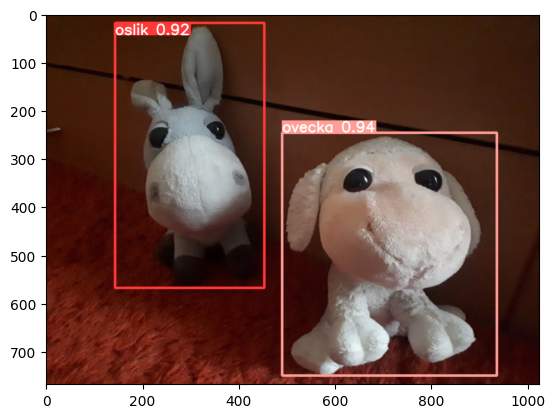

In [25]:
# Test sample 1
best_model = YOLO(f"{latest_run}/weights/best.pt")
results = best_model("./datasets/2plysaci/test/20181209_092837.jpg") 
res_plotted = results[0].plot()
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))


image 1/1 /mnt/batch/tasks/shared/LS_root/mounts/clusters/a100/code/datasets/prasatko/test/20230622_082741_jpg.rf.bd538043dbabadd6ba916d54f6946699.jpg: 608x1024 1 oslik, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)


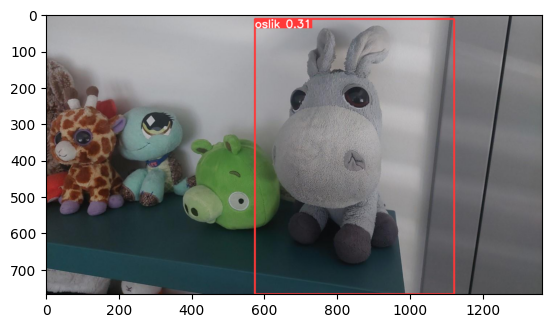

In [31]:
# Picture with pig also
results = best_model("./datasets/prasatko/test/20230622_082741_jpg.rf.bd538043dbabadd6ba916d54f6946699.jpg", conf=0.1) 
res_plotted = results[0].plot()
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))

In [20]:
# Store this model
import shutil
shutil.copy(f"{latest_run}/weights/best.pt", "2plysaci_custom_n.pt")

'2plysaci_custom_n.pt'

## Transfer learning on new data
Suppose we have new data, new toy - pig. Let's leverage model weights we trained in previous step to cheaply train new model for pigs.

Note it is classic transfer learning so model will recognize ONLY new data so we might need to use both original and new model for full task in our application.

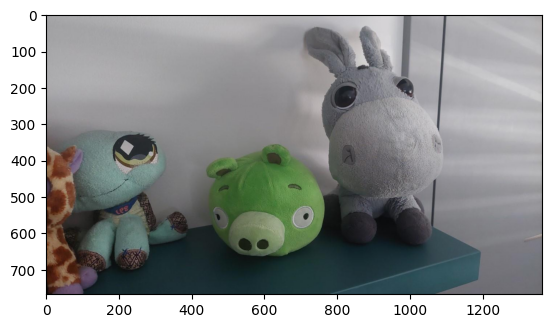

In [33]:
# Show one image from dataset
%matplotlib inline
from matplotlib import pyplot as plt
img = cv2.imread("./datasets/prasatko/valid/images/20230622_082734_jpg.rf.6b2d394943c0fbd7fda1761c9af7ef74.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [34]:
# Load model_2plysaci
model = YOLO('2plysaci_custom_n.pt')

In [35]:
# Train the model
train = model.train(data='./datasets/prasatko.yaml', epochs=100, patience=0, imgsz=1024)

# 100 epochs completed in 0.025 hours.

New https://pypi.org/project/ultralytics/8.0.121 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.120 🚀 Python-3.8.5 torch-1.12.0 CUDA:0 (NVIDIA A100 80GB PCIe, 80995MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
yolo/engine/trainer: task=detect, mode=train, model=2plysaci_custom_n.pt, data=./datasets/prasatko.yaml, epochs=100, patience=0, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, lin

Exception: UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.4e283308-b47b-4a0f-b027-483494b46690/last.pt already exists.

In [36]:
# Find folder with latest run of training
import os

files = os.listdir("runs/detect/")
max_number = 0
latest_run = ""
for file in files:
    if file.split("train")[1]:
        number = int(file.split("train")[1])
        max_number = max(max_number, number)
if max_number == 0:
    latest_run = "runs/detect/train"
else:
    latest_run = "runs/detect/train" + str(max_number)
print(latest_run)

runs/detect/train30



image 1/1 /mnt/batch/tasks/shared/LS_root/mounts/clusters/a100/code/datasets/prasatko/test/20230622_082854.jpg: 608x1024 1 prasatko, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)


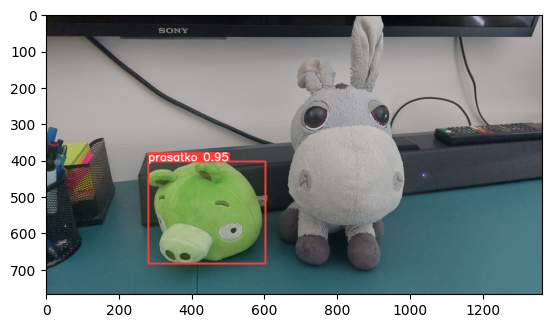

In [40]:
# Test sample 1
best_model = YOLO(f"{latest_run}/weights/best.pt")
results = best_model("./datasets/prasatko/test/20230622_082854.jpg") 
res_plotted = results[0].plot()
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))


image 1/1 /mnt/batch/tasks/shared/LS_root/mounts/clusters/a100/code/datasets/prasatko/test/20230622_082741_jpg.rf.bd538043dbabadd6ba916d54f6946699.jpg: 608x1024 2 prasatkos, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)


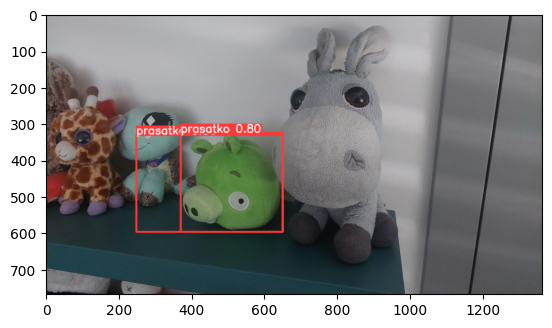

In [41]:
# Test sample 2
best_model = YOLO(f"{latest_run}/weights/best.pt")
results = best_model("./datasets/prasatko/test/20230622_082741_jpg.rf.bd538043dbabadd6ba916d54f6946699.jpg") 
res_plotted = results[0].plot()
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))

In [ ]:
# Store this model
import shutil
shutil.copy(f"{latest_run}/weights/best.pt", "transfer_new_data_only.pt")

# Start with current weights but train on all old and new data
In this example we will get previous weights as starting point to save on epochs, but will train model on all data.

With that we will get universtal 3-class model, but training will take longer (not too much as our dataset is so small, but if base one is really large, it will take a while).

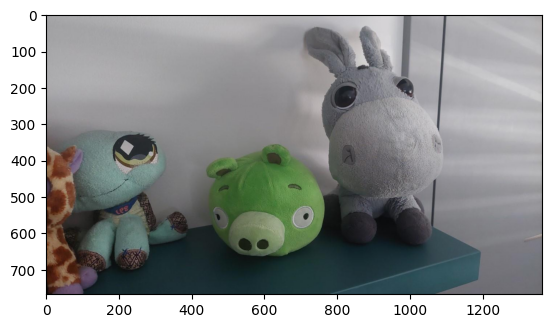

In [ ]:
# Show one image from dataset
%matplotlib inline
from matplotlib import pyplot as plt
img = cv2.imread("./datasets/3plysaci/valid/images/20230622_082734_jpg.rf.6b2d394943c0fbd7fda1761c9af7ef74.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
# Load model_2plysaci
model = YOLO('2plysaci_custom_n.pt')

In [ ]:
# Train the model
train = model.train(data='./datasets/3plysaci.yaml', epochs=100, patience=0, imgsz=1024)

# 100 epochs completed in 0.025 hours.

In [ ]:
# Find folder with latest run of training
import os

files = os.listdir("runs/detect/")
max_number = 0
latest_run = ""
for file in files:
    if file.split("train")[1]:
        number = int(file.split("train")[1])
        max_number = max(max_number, number)
if max_number == 0:
    latest_run = "runs/detect/train"
else:
    latest_run = "runs/detect/train" + str(max_number)
print(latest_run)

In [ ]:
# Test sample 1
best_model = YOLO(f"{latest_run}/weights/best.pt")
results = best_model("./datasets/prasatko/test/20230622_082854.jpg") 
res_plotted = results[0].plot()
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))

In [ ]:
# Test sample 2
best_model = YOLO(f"{latest_run}/weights/best.pt")
results = best_model("./datasets/prasatko/test/20230622_082741_jpg.rf.bd538043dbabadd6ba916d54f6946699.jpg") 
res_plotted = results[0].plot()
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))

In [ ]:
# Store this model
import shutil
shutil.copy(f"{latest_run}/weights/best.pt", "transfer_all_data.pt")

# Retrain full model with all data
Now let's compare time needed to retrain model from scratch using all data and compare model performance.

In [ ]:
# Load empty model
model = YOLO('yolov8n.yaml')

In [ ]:
# Train the model
train = model.train(data='./datasets/3plysaci.yaml', epochs=2000, patience=0, imgsz=1024)

# 1000 epochs completed in 0.275 hours.

In [ ]:
# Find folder with latest run of training
import os

files = os.listdir("runs/detect/")
max_number = 0
latest_run = ""
for file in files:
    if file.split("train")[1]:
        number = int(file.split("train")[1])
        max_number = max(max_number, number)
if max_number == 0:
    latest_run = "runs/detect/train"
else:
    latest_run = "runs/detect/train" + str(max_number)
print(latest_run)

In [ ]:
# Test sample 1
best_model = YOLO(f"{latest_run}/weights/best.pt")
results = best_model("./datasets/prasatko/test/20230622_082854.jpg") 
res_plotted = results[0].plot()
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))

In [ ]:
# Test sample 2
best_model = YOLO(f"{latest_run}/weights/best.pt")
results = best_model("./datasets/prasatko/test/20230622_082741_jpg.rf.bd538043dbabadd6ba916d54f6946699.jpg") 
res_plotted = results[0].plot()
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))

In [ ]:
# Store this model
import shutil
shutil.copy(f"{latest_run}/weights/best.pt", "3plysaci_custom_n.pt")